In [1]:
using GeometricIntegrators

In [2]:
set_config(:nls_stol_break, Inf);

In [3]:
using Plots
using GeometricProblems.PlotRecipes

In [4]:
#plotlyjs()
gr()

Plots.GRBackend()

#### Load example problem: guiding centre particle in ITER-like Solov'ev equilibrium

In [5]:
using ChargedParticleDynamics.GyroKinetics4d.GuidingCenter4dSolovevIterXpoint

┌ Info: Precompiling ChargedParticleDynamics [209b3593-7183-5600-9f8f-df5ce7fddd64]
└ @ Base loading.jl:1260
┌ Info: Skipping precompilation since __precompile__(false). Importing ChargedParticleDynamics [209b3593-7183-5600-9f8f-df5ce7fddd64].
└ @ Base loading.jl:1033


In [6]:
using ChargedParticleDynamics.GyroKinetics4d.GuidingCenter4dSolovevIterXpoint: equ

#### Get initial conditions and parameters

In [7]:
q0, params = initial_conditions_trapped()
#q0, params = initial_conditions_barely_passing()
#q0, params = initial_conditions_barely_trapped()
#q0, params = initial_conditions_deeply_passing()
#q0, params = initial_conditions_deeply_trapped()

([230.01991056352358, 0.0, 0.0, -0.40746384156967036], (μ = 1.88e-7, R₀ = 6.2, ω₀ = 203.73192078483518, scaling_factor = [203.73192078483518, 203.73192078483518, 203.73192078483518, 203.73192078483518]))

#### Set time step and number of steps to integrate

In [8]:
nt  = 10000;
Δt  = 10000.;

## Reference Integrator: Explicit Runge-Kutta, 4th Order

#### Construct reference tableau, ode, solution and integrator

In [9]:
ref = getTableauERK4()
ode = guiding_center_4d_ode(q0, params)
sol = Solution(ode, Δt, nt)
int = Integrator(ode, ref, Δt)
;

#### Integrate with standard explicit Runge-Kutta method

In [10]:
integrate!(int, sol)

#### Scale Solution

In [11]:
for i in 0:nt
    sol.q[:,i] .= transform_q̃_to_q(sol.t[i], sol.q[:,i], params)
end

#### Plot reference solution (projection on poloidal plane)

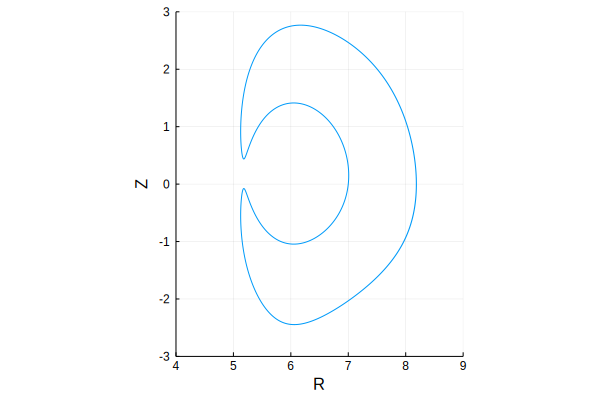

In [12]:
plot(sol.q[1,:].*equ.R₀, sol.q[2,:].*equ.R₀, xlabel="R", ylabel="Z", xlim=(4,9), ylim=(-3,+3), aspect_ratio=:equal, legend=:none)

#### Plot energy error of reference solution

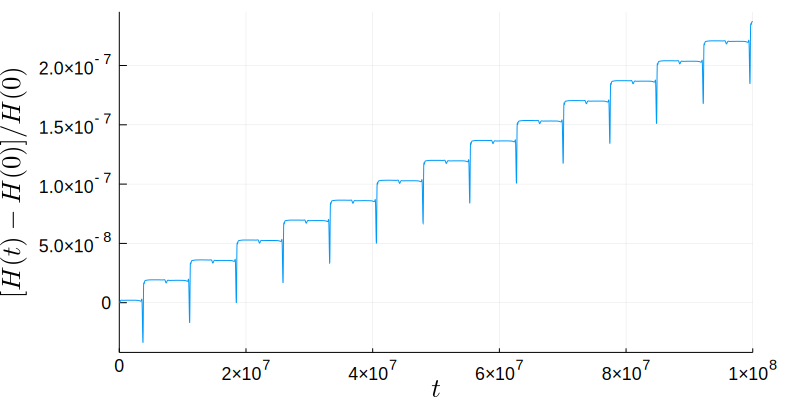

In [13]:
plotenergyerror(sol, energy = (t,q) -> hamiltonian(t,q,params))

## Reference Integrator: Implicit Midpoint

In [14]:
set_config(:nls_atol, 2eps())
set_config(:nls_rtol, 2eps())

4.440892098500626e-16

#### Construct reference tableau, ode, solution and integrator

In [15]:
ref = getTableauGLRK(1)
ode = guiding_center_4d_ode(q0, params)
sol = Solution(ode, Δt, nt)
int = Integrator(ode, ref, Δt)
;

#### Integrate with standard Gauss-Legendre Runge-Kutta method

In [16]:
integrate!(int, sol)

#### Scale Solution

In [17]:
for i in 0:nt
    sol.q[:,i] .= transform_q̃_to_q(sol.t[i], sol.q[:,i], params)
end

#### Plot reference solution (projection on poloidal plane)

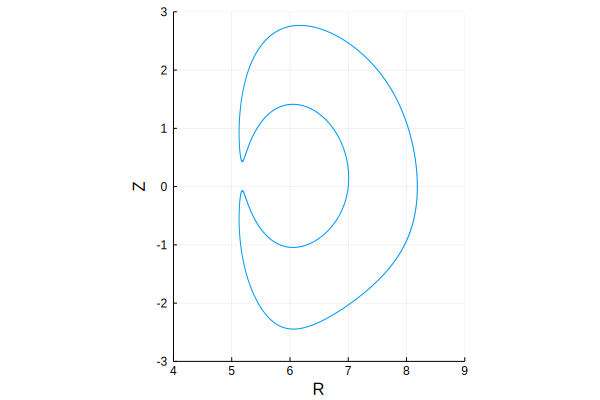

In [18]:
plot(sol.q[1,:].*equ.R₀, sol.q[2,:].*equ.R₀, xlabel="R", ylabel="Z", xlim=(4,9), ylim=(-3,+3), aspect_ratio=:equal, legend=:none)

#### Plot energy error of reference solution

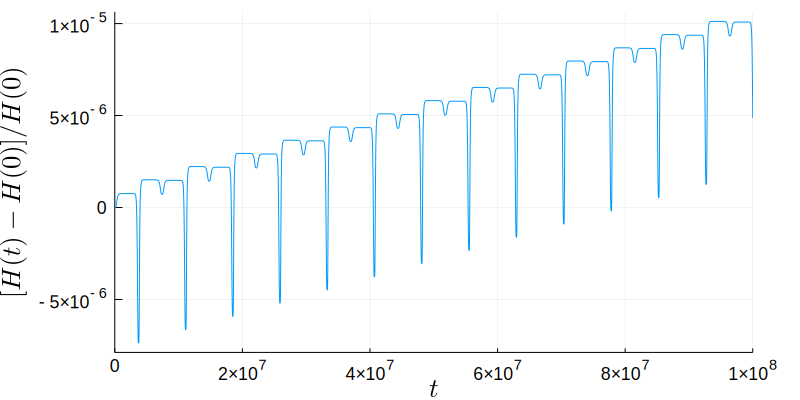

In [19]:
plotenergyerror(sol, energy = (t,q) -> hamiltonian(t,q,params))

## Splitting Integrator

In [20]:
set_config(:nls_atol, 1E-15)
set_config(:nls_rtol, 1E-14)
set_config(:nls_nmax, 20);

#### Construct splitting tableau, sode, solution and integrator

In [21]:
stab = getTableauStrang()
sode = guiding_center_4d_sode(q0, params)
ssol = Solution(sode, Δt, nt)
ints = Tuple(IntegratorConstructor(eltype(q0), ndims(sode), ref) for i in 1:6)
sint = IntegratorComposition(sode, ints, stab, Δt)
;

#### Integrate with splitting method

In [22]:
integrate!(sint, ssol)

#### Scale Solution

In [23]:
for i in 0:nt
    ssol.q[:,i] .= transform_q̃_to_q(sol.t[i], ssol.q[:,i], params)
end

#### Plot splitting solution (projection on poloidal plane)

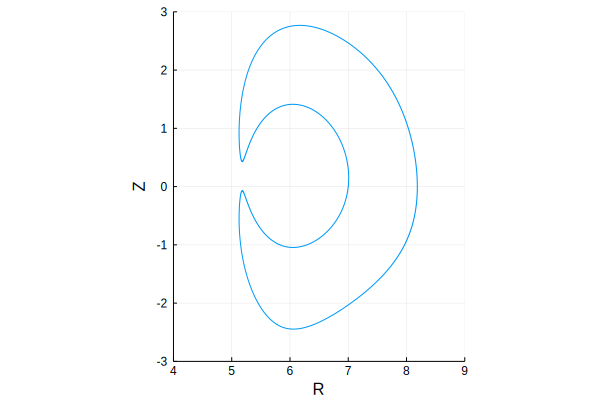

In [24]:
plot(ssol.q[1,:].*equ.R₀, ssol.q[2,:].*equ.R₀, xlabel="R", ylabel="Z", xlim=(4,9), ylim=(-3,+3), aspect_ratio=:equal, legend=:none)

#### Plot energy error of splitting solution

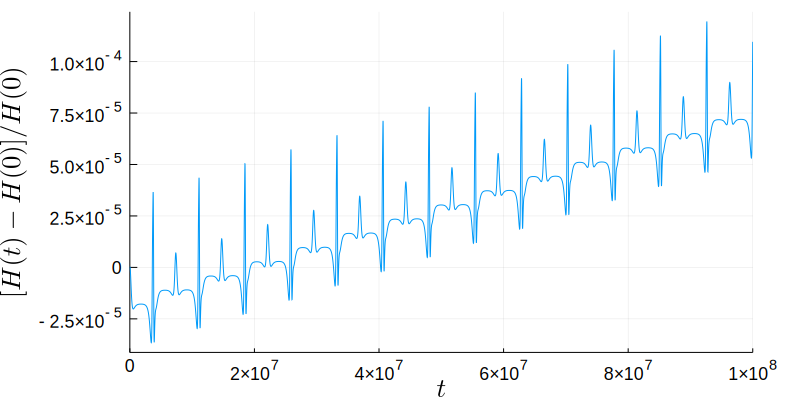

In [25]:
plotenergyerror(ssol, energy = (t,q) -> hamiltonian(t,q,params))